<h1>Importing libraries and loading dataset</h1>

In [1]:
!pip install bioinfokit

In [2]:
!pip install scikit_posthocs

In [3]:
!pip install pingouin

In [4]:
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
import statsmodels.api as sm
import pingouin as pg
from statsmodels.formula.api import ols
from sklearn.linear_model import LinearRegression
from statsmodels.graphics.factorplots import interaction_plot
import scikit_posthocs as sp
from bioinfokit.analys import stat


In [5]:
df = pd.read_csv('diabetes.csv')

df.head(5)

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6      148             72             35        0  33.6   
1            1       85             66             29        0  26.6   
2            8      183             64              0        0  23.3   
3            1       89             66             23       94  28.1   
4            0      137             40             35      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

In [6]:
#summary statistics of the initial dataset

df.describe()

Pregnancies     Glucose  BloodPressure  SkinThickness     Insulin  \
count   768.000000  768.000000     768.000000     768.000000  768.000000   
mean      3.845052  120.894531      69.105469      20.536458   79.799479   
std       3.369578   31.972618      19.355807      15.952218  115.244002   
min       0.000000    0.000000       0.000000       0.000000    0.000000   
25%       1.000000   99.000000      62.000000       0.000000    0.000000   
50%       3.000000  117.000000      72.000000      23.000000   30.500000   
75%       6.000000  140.250000      80.000000      32.000000  127.250000   
max      17.000000  199.000000     122.000000      99.000000  846.000000   

              BMI  DiabetesPedigreeFunction         Age     Outcome  
count  768.000000                768.000000  768.000000  768.000000  
mean    31.992578                  0.471876   33.240885    0.348958  
std      7.884160                  0.331329   11.760232    0.476951  
min      0.000000                  0.078000   21.000000    0.000000  
25%     27.300000                  0.243750   24.000000    0.000000  
50%     32.000000                  0.372500   29.000000    0.000000  
75%     36.600000                  0.626250   41.000000    1.000000  
max     67.100000                  2.420000   81.000000    1.000000

<h3>Data cleaning</h3>

In [7]:
#how many 0s do we have in each column?

cols_all = df.columns.to_list()
#print(cols_all)

num_zeroes = pd.DataFrame({'Column':[],'Number of 0s':[]})

for col in cols_all:
    num_zeroes = num_zeroes.append(
        {'Column':col,'Number of 0s':(df[col]==0).sum()}
        ,ignore_index=True
        )
    
num_zeroes

Column  Number of 0s
0               Pregnancies         111.0
1                   Glucose           5.0
2             BloodPressure          35.0
3             SkinThickness         227.0
4                   Insulin         374.0
5                       BMI          11.0
6  DiabetesPedigreeFunction           0.0
7                       Age           0.0
8                   Outcome         500.0

In [8]:
#replace those 0s with the mean for columns that physically cannot be 0

zero_cols = ['Glucose','BloodPressure','SkinThickness','BMI']

for col in zero_cols:
    df.loc[df[col]==0,col]=df[col].mean()
    
df.head()

Pregnancies  Glucose  BloodPressure  SkinThickness  Insulin   BMI  \
0            6    148.0           72.0      35.000000        0  33.6   
1            1     85.0           66.0      29.000000        0  26.6   
2            8    183.0           64.0      20.536458        0  23.3   
3            1     89.0           66.0      23.000000       94  28.1   
4            0    137.0           40.0      35.000000      168  43.1   

   DiabetesPedigreeFunction  Age  Outcome  
0                     0.627   50        1  
1                     0.351   31        0  
2                     0.672   32        1  
3                     0.167   21        0  
4                     2.288   33        1

We're going to limit the analysis to certain variables: BloodPressure (quantitative dependent variable of interest), Age, Outcome, Pregnancies, Glucose, BMI.


Reasons: They're more easily interpertable and relatable, and have health implications outside just diabetes.

In [9]:
cols_selected = ['BloodPressure','Pregnancies','Glucose','BMI','Age','Outcome',]
df = df[cols_selected]
df.head(5)

BloodPressure  Pregnancies  Glucose   BMI  Age  Outcome
0           72.0            6    148.0  33.6   50        1
1           66.0            1     85.0  26.6   31        0
2           64.0            8    183.0  23.3   32        1
3           66.0            1     89.0  28.1   21        0
4           40.0            0    137.0  43.1   33        1

In [10]:
#binning age into groups:

labels= ['20 to 29','30 to 39','40 to 49','50 to 59','60+']

df['Age_bin'] = pd.cut(df['Age'],
                       bins=[20,30,40,50,60,max(df['Age'])+1],
                       right=False,
                       labels=labels)
                        
#df.head()

pd.DataFrame(df['Age_bin'].value_counts())

Age_bin
20 to 29      396
30 to 39      165
40 to 49      118
50 to 59       57
60+            32

In [11]:
#summary statistics after cleaning

df.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  \
count     768.000000   768.000000  768.000000  768.000000  768.000000   
mean       72.254807     3.845052  121.681605   32.450805   33.240885   
std        12.115932     3.369578   30.436016    6.875374   11.760232   
min        24.000000     0.000000   44.000000   18.200000   21.000000   
25%        64.000000     1.000000   99.750000   27.500000   24.000000   
50%        72.000000     3.000000  117.000000   32.000000   29.000000   
75%        80.000000     6.000000  140.250000   36.600000   41.000000   
max       122.000000    17.000000  199.000000   67.100000   81.000000   

          Outcome  
count  768.000000  
mean     0.348958  
std      0.476951  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

<h1>Exploratory Data Analysis</h1>

In [12]:
sns.set_theme(style='whitegrid',palette='bright')

In [13]:
pd.crosstab(df.Age_bin, df.Outcome,margins=True)

Outcome     0    1  All
Age_bin                
20 to 29  312   84  396
30 to 39   89   76  165
40 to 49   53   65  118
50 to 59   23   34   57
60+        23    9   32
All       500  268  768

In [14]:
#histogram of blood pressure

sns.histplot(data=df,x='BloodPressure')
plt.title('Histogram of Diastolic Blood Pressure (all)')
plt.show()

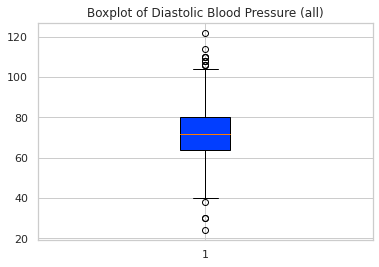

In [15]:
#boxplot of BP
#in matplotlib because apparently seaborn doesn't like vert boxplots
#with only one axis

plt.boxplot(data=df,x='BloodPressure',patch_artist=True)
plt.title('Boxplot of Diastolic Blood Pressure (all)')
plt.show()

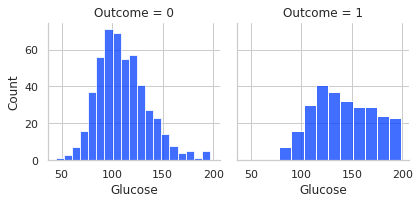

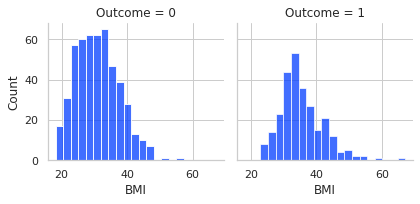

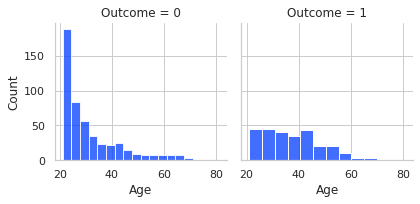

In [16]:
#and histograms of the others in case there's anything interesting

for col in cols_selected[:-1]:
    g = sns.FacetGrid(data=df,col='Outcome',margin_titles=True)
    g.map(sns.histplot,col)
    plt.show()

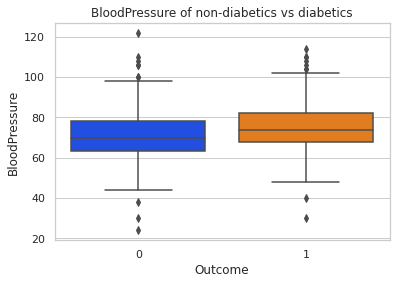

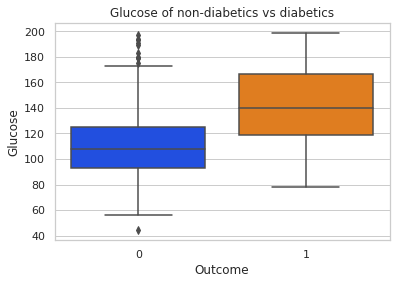

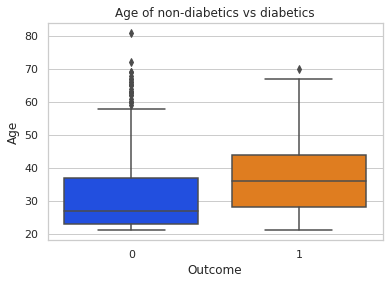

In [17]:
#boxplots of BP and other variables

for col in cols_selected[:-1]:
    sns.boxplot(data=df,x='Outcome',y=col)
    plt.title(f'{col} of non-diabetics vs diabetics')
    plt.show()

<h4>EDA for blood pressure across age categories<h/4>

In [18]:
#blood pressure and age categories

sns.boxplot(data=df,x='Age_bin',y='BloodPressure')
plt.title('Blood Pressure & Age')

plt.show()

In [19]:
g = sns.FacetGrid(data=df,col='Age_bin',margin_titles=True)
g.map(sns.histplot,'BloodPressure')
plt.show()

In [20]:
#quick scatterplot to look at the relationship of age and BP...

m = {0:'.',1:'X'}
sns.scatterplot(
    data=df,x='Age',y='BloodPressure',hue='Outcome',style='Outcome',
    markers=m,palette=['red','blue']
    )
plt.title('Blood Pressure vs Age')
plt.show()


In [21]:
#and then some box and violin plots

sns.boxplot(
    data=df, x="Age_bin", y="BloodPressure", hue='Outcome'
    )
plt.title('Boxplots of Blood Pressure across Age and Outcome')
plt.show()

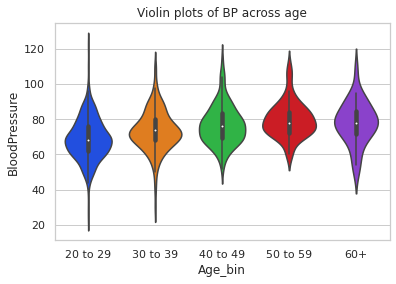

In [22]:
#categories separately, then together in split violin below

ax = sns.violinplot(data=df,x='Age_bin',y='BloodPressure')
plt.title('Violin plots of BP across age')
plt.show()

ax = sns.violinplot(data=df,x='Outcome',y='BloodPressure')
plt.title('Violin plots of BP across diabetic outcome')
plt.show()

In [23]:
sns.violinplot(data=df,x='Age_bin',y='BloodPressure',hue='Outcome',split=True)
plt.title('Split violin plots of BP across Age and Outcome')
plt.show()

Testing normality and constancy of variance (we'll get to testing these assumptions for residuals later too)

In [24]:
#normality:

w, pvalue = stats.shapiro(df['BloodPressure'])
print(f'w={w}, p-value={pvalue}')

w=0.9878163933753967, p-value=5.254140432953136e-06


In [25]:
#constancy of variance across outcome cats:

w, pvalue = stats.levene(
    df.loc[df['Outcome']==0]['BloodPressure'],
    df.loc[df['Outcome']==1]['BloodPressure']
    )

print(f'w={w}, p-value={pvalue}')

w=0.00017964008680908006, p-value=0.9893097729572887


In [26]:
#across age bins:
#I'm sure I can do this with a for loop but can't be bothered right now

w, pvalue = stats.levene(
    df.loc[df['Age_bin']=='20 to 29']['BloodPressure'],
    df.loc[df['Age_bin']=='30 to 39']['BloodPressure'],
    df.loc[df['Age_bin']=='40 to 49']['BloodPressure'],
    df.loc[df['Age_bin']=='50 to 59']['BloodPressure'],
    df.loc[df['Age_bin']=='60+']['BloodPressure'],
    )

print(f'w={w}, p-value={pvalue}')

w=0.573960296692915, p-value=0.6816074528668733


These suggest blood pressure is not normally distributed, but variance is constant across outcome and age groups.

In [27]:
#just to be sure we get the same result with bioinfokit...

x = stat()
x.levene(df=df,res_var='BloodPressure',xfac_var='Age_bin')
x.levene_summary


Parameter   Value
0      Test statistics (W)  0.5740
1  Degrees of freedom (Df)  4.0000
2                  p value  0.6816

<h2>T-tests</h2>

H_0: BP is the same between outcome categories (diabetic and non-diabetic)

H_1: BP is different between outcomes

In [28]:
#first let's split the data to make it easier

df_0 = df[df['Outcome']==0]
df_1 = df[df['Outcome']==1]


In [29]:
df_0.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  Outcome
count     500.000000   500.000000  500.000000  500.000000  500.000000    500.0
mean       70.810008     3.298000  110.705367   30.880066   31.190000      0.0
std        11.932269     3.017185   24.715021    6.503051   11.667655      0.0
min        24.000000     0.000000   44.000000   18.200000   21.000000      0.0
25%        63.500000     1.000000   93.000000   25.750000   23.000000      0.0
50%        70.000000     2.000000  107.500000   30.400000   27.000000      0.0
75%        78.000000     5.000000  125.000000   35.300000   37.000000      0.0
max       122.000000    13.000000  197.000000   57.300000   81.000000      0.0

In [30]:
df_1.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  Outcome
count     268.000000   268.000000  268.000000  268.000000  268.000000    268.0
mean       74.950326     4.865672  142.159661   35.381288   37.067164      1.0
std        12.016572     3.741239   29.545943    6.596733   10.968254      0.0
min        30.000000     0.000000   78.000000   22.900000   21.000000      1.0
25%        68.000000     1.750000  119.000000   30.900000   28.000000      1.0
50%        74.000000     4.000000  140.000000   34.250000   36.000000      1.0
75%        82.000000     8.000000  167.000000   38.775000   44.000000      1.0
max       114.000000    17.000000  199.000000   67.100000   70.000000      1.0

In [31]:
#to summarize BP, our outcome variable, for diabetics vs non-diabetics:

pd.DataFrame({
    '0 (non-diabetic)':df_0['BloodPressure'].describe(),
    '1 (diabetic)':df_1['BloodPressure'].describe(),
    })

0 (non-diabetic)  1 (diabetic)
count        500.000000    268.000000
mean          70.810008     74.950326
std           11.932269     12.016572
min           24.000000     30.000000
25%           63.500000     68.000000
50%           70.000000     74.000000
75%           78.000000     82.000000
max          122.000000    114.000000

In [32]:
#and summary stats of BP across age bins

pd.DataFrame({
    agebin:df[df['Age_bin']==agebin]['BloodPressure'].describe() 
    for agebin in labels
    })

20 to 29    30 to 39    40 to 49    50 to 59         60+
count  396.000000  165.000000  118.000000   57.000000   32.000000
mean    68.838660   73.436056   76.868876   79.807018   77.972046
std     11.771658   11.514077   11.062986   10.007923   12.081828
min     24.000000   30.000000   52.000000   60.000000   50.000000
25%     62.000000   68.000000   69.105469   72.000000   71.500000
50%     68.000000   74.000000   76.000000   78.000000   78.000000
75%     76.000000   80.000000   83.500000   84.000000   84.500000
max    122.000000  110.000000  114.000000  110.000000  108.000000

In [33]:
#now let's try t-tests for each one

ttest_results = pd.DataFrame({'Variable':[],'t-statistic':[],'p-value':[]})

for col in cols_selected[:-1]:
    tStat, pValue = stats.ttest_ind(df_0[col],df_1[col],equal_var=False)
    ttest_results = ttest_results.append(
        {'Variable':col,'t-statistic':tStat,'p-value':pValue},
        ignore_index=True
    )
    
ttest_results

Variable  t-statistic       p-value
0  BloodPressure    -4.562334  6.260424e-06
1    Pregnancies    -5.906961  6.821926e-09
2        Glucose   -14.862435  3.163533e-41
3            BMI    -9.057760  2.435552e-18
4            Age    -6.920738  1.201513e-11

From simple t-tests, all of these appear statistically significant (p-value < 0.05)

Graphing distribution of BP:

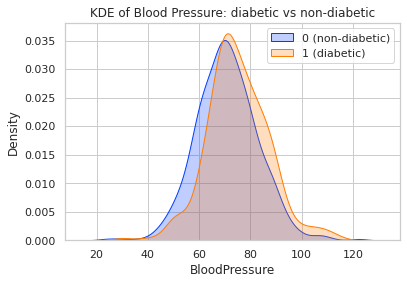

In [34]:
sns.kdeplot(data=df_0['BloodPressure'],shade=True)
sns.kdeplot(data=df_1['BloodPressure'],shade=True)
plt.title('KDE of Blood Pressure: diabetic vs non-diabetic')
plt.legend(['0 (non-diabetic)','1 (diabetic)'])
plt.show()

Other quantitative variables just to see:

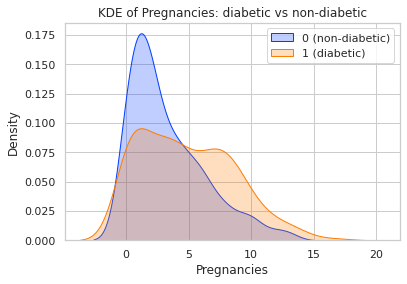

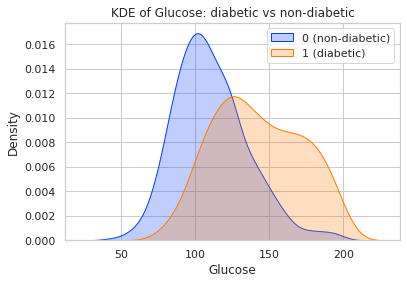

In [35]:
for col in cols_selected[1:-1]:
    sns.kdeplot(data=df_0[col],shade=True)
    sns.kdeplot(data=df_1[col],shade=True)
    plt.title(f'KDE of {col}: diabetic vs non-diabetic')
    plt.legend(['0 (non-diabetic)','1 (diabetic)'])
    plt.show()
    
    

<h2>Linear Regressions</h2>

<h3>Simple linear regression (BP vs Age)</h3>

In [36]:
x = df['Age'].values.reshape(-1,1)
y = df['BloodPressure']

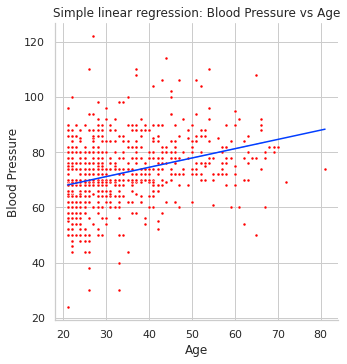

In [37]:
lr_model = LinearRegression()
lr_model.fit(x, y)
y_pred = lr_model.predict(x)

sns.relplot(x=df['Age'],y=y_pred,kind='line')
sns.scatterplot(
    x=df['Age'],y=df['BloodPressure'],color='red',marker='.'
    )
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title('Simple linear regression: Blood Pressure vs Age')
plt.show()

In [38]:
print(f'Coefficient: {lr_model.coef_[0]}')
print(f'intercept: {lr_model.intercept_}')
print(f'R^2 score: {lr_model.score(x,y)}')

Coefficient: 0.33662282904929053
intercept: 61.06516562949305
R^2 score: 0.1067591851504931


In [39]:
#same ols again in scipy because it includes p-value

res = stats.linregress(x=df['Age'],y=df['BloodPressure'])

print(f'coeff: {res.slope}')
print(f'intercept: {res.intercept}')
print(f'p-value: {res.pvalue}')
print(f'r^2: {res.rvalue**2}')
print(f'std err: {res.stderr}')

coeff: 0.33662282904929103
intercept: 61.06516562949304
p-value: 1.4515438152916903e-20
r^2: 0.10675918515049326
std err: 0.035181215095340154


In [40]:
#calculating confidence intervals for slope and intercept, using t-dist

tinv = lambda p, df: abs(stats.t.ppf(p/2, df))

In [41]:
ts = tinv(0.05, df.shape[0]-1)
print(f"slope (95%): {res.slope:.4f} +/- {ts*res.stderr:.4f}")

print(f"intercept (95%): {res.intercept:.4f}"
      f" +/- {ts*res.intercept_stderr:.4f}")

slope (95%): 0.3366 +/- 0.0691
intercept (95%): 61.0652 +/- 2.4350


In [42]:
#viewing the residuals

df_lr_pred = pd.DataFrame({'Actual': y, 'Predicted': y_pred})
df_lr_pred.head(10)

Actual  Predicted
0  72.000000  77.896307
1  66.000000  71.500473
2  64.000000  71.837096
3  66.000000  68.134245
4  40.000000  72.173719
5  74.000000  71.163851
6  50.000000  69.817359
7  69.105469  70.827228
8  70.000000  78.906176
9  96.000000  79.242798

In [43]:
from sklearn import metrics
print('Mean Absolute Error:', metrics.mean_absolute_error(y, y_pred))
print('Mean Squared Error:', metrics.mean_squared_error(y, y_pred))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y, y_pred)))

Mean Absolute Error: 8.66906499953217
Mean Squared Error: 130.95326428961815
Root Mean Squared Error: 11.443481301143379


In [44]:
#plotting the residuals to see their distribution...

sns.residplot(data=df,x='Age',y='BloodPressure')
plt.title('Residuals of simple linear regression')

Text(0.5, 1.0, 'Residuals of simple linear regression')

The shape of the residual plot shows variance is a lot higher among lower ages; we'll explore this more when doing ANOVA.

Now, what happens if we try to run separate regressions on people with and without diabetes?

In [45]:
x_diab = df_1['Age'].values.reshape(-1,1)
y_diab = df_1['BloodPressure']

x_ndiab = df_0['Age'].values.reshape(-1,1)
y_ndiab = df_0['BloodPressure']

In [46]:
lr_model_diab = LinearRegression()
lr_model_diab.fit(x_diab, y_diab)
y_pred_diab = lr_model_diab.predict(x_diab)

lr_model_ndiab = LinearRegression()
lr_model_ndiab.fit(x_ndiab, y_ndiab)
y_pred_ndiab = lr_model_ndiab.predict(x_ndiab)

In [47]:
print('People with diabetes:')
print(f'Coefficient: {lr_model_diab.coef_[0]:.4f}')
print(f'intercept: {lr_model_diab.intercept_:.4f}')
print(f'R^2 score: {lr_model_diab.score(x,y):.4f}')

print('\nPeople without diabetes:')
print(f'Coefficient: {lr_model_ndiab.coef_[0]:.4f}')
print(f'intercept: {lr_model_ndiab.intercept_:.4f}')
print(f'R^2 score: {lr_model_ndiab.score(x,y):.4f}\n')

People with diabetes:
Coefficient: 0.3231
intercept: 62.9746
R^2 score: 0.0921

People without diabetes:
Coefficient: 0.3104
intercept: 61.1289
R^2 score: 0.1017



In [48]:
##in scipy again bc built-in p-values!!

res_0 = stats.linregress(x=df_0['Age'],y=df_0['BloodPressure'])

print('Simple LR on people without diabetes:\n',
    res_0)

res_1 = stats.linregress(x=df_1['Age'],y=df_1['BloodPressure'])

print('\nSimple LR on people with diabetes:\n',
    res_1)

Simple LR on people without diabetes:
 LinregressResult(slope=0.3103909310897683, intercept=61.12891467181013, rvalue=0.3035075826324537, pvalue=4.094680823906528e-12, stderr=0.04366563537171635, intercept_stderr=1.4539266555179455)

Simple LR on people with diabetes:
 LinregressResult(slope=0.32308086244414147, intercept=62.97463512119365, rvalue=0.29489548680202915, pvalue=8.88675651205884e-07, stderr=0.06418689907915436, intercept_stderr=2.480828513832322)


In [49]:
#confidence intervals for slope + intercept

ts_0 = tinv(0.05, df_0.shape[0]-1)

print('Non-diabetics:')
print(f"slope (95%): {res_0.slope:.4f} +/- {ts_0*res_0.stderr:.4f}")
print(f"intercept (95%): {res_0.intercept:.4f}"
      f" +/- {ts_0*res_0.intercept_stderr:.4f}\n")

ts_1 = tinv(0.05, df_1.shape[0]-1)

print('Diabetics:')
print(f"slope (95%): {res_1.slope:.4f} +/- {ts_1*res_1.stderr:.4f}")
print(f"intercept (95%): {res_1.intercept:.4f}"
      f" +/- {ts_1*res_1.intercept_stderr:.4f}")

Non-diabetics:
slope (95%): 0.3104 +/- 0.0858
intercept (95%): 61.1289 +/- 2.8566

Diabetics:
slope (95%): 0.3231 +/- 0.1264
intercept (95%): 62.9746 +/- 4.8845


We can seee that along with similar R^2, the slopes and intercepts are quite similar, which can also be shown graphically...

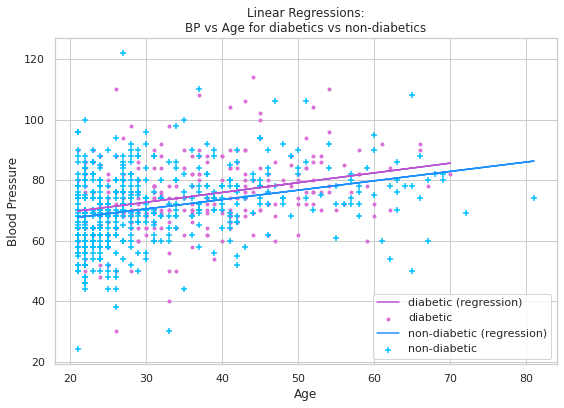

In [50]:
#yes I know there's a function for this in seaborn already
#this is here anyway to make sure I understand which line means what

plt.figure(figsize=(9,6))
plt.plot(df_1['Age'],y_pred_diab,color='#BA55D3')
plt.scatter(
    df_1['Age'],df_1['BloodPressure'],color='orchid',marker='.'
    )
plt.plot(df_0['Age'],y_pred_ndiab,color='#1E90FF')
plt.scatter(
    x=df_0['Age'],y=df_0['BloodPressure'],color='#00BFFF',marker='+'
    )
plt.legend(
    ['diabetic (regression)',
     'diabetic',
     'non-diabetic (regression)',
     'non-diabetic'])
plt.xlabel('Age')
plt.ylabel('Blood Pressure')
plt.title('Linear Regressions:\nBP vs Age for diabetics vs non-diabetics')
plt.show()

In [51]:
sns.lmplot(
    data=df,x='Age',y='BloodPressure',markers=['.','x'],hue='Outcome'
    )
plt.title('Linear Regressions:\nBP vs Age for diabetics vs non-diabetics')
plt.show()

<h3>Multiple Linear Regression</h3>

In [52]:
#categories to use for MLR

predict_cats = ['Pregnancies','Glucose','BMI','Age','Outcome']

x_mult = df[predict_cats]
y_mult = df['BloodPressure']

In [53]:
mult_lr = LinearRegression()
mult_lr.fit(x_mult,y_mult)

LinearRegression()

In [54]:
print(f'Coefficients: {mult_lr.coef_}')
print(f'intercept: {mult_lr.intercept_}')
print(f'R^2 score: {mult_lr.score(x_mult,y_mult)}')

Coefficients: [ 0.17962621  0.04029814  0.46539779  0.28520246 -1.17986589]
intercept: 42.4894010676046
R^2 score: 0.18983072411900337


In [55]:
#which coefficient is which?

print('Coefficients:')
for i in range(len(predict_cats)):
    print(f'{predict_cats[i]}: {mult_lr.coef_[i]}')

Coefficients:
Pregnancies: 0.17962620787253286
Glucose: 0.04029813691858247
BMI: 0.4653977881744712
Age: 0.28520246433595464
Outcome: -1.179865890856556


In [56]:
y_pred_mult = mult_lr.predict(x_mult)

df_2 = pd.DataFrame({
    'Age': df['Age'],
    'Actual': y_mult,
    'Predicted': y_pred_mult,
    'Residual': y_mult - y_pred_mult})
df_2.head()

Age  Actual  Predicted   Residual
0   50    72.0  78.248906  -6.248906
1   31    66.0  67.315226  -1.315226
2   32    64.0  70.091351  -6.091351
3   21    66.0  65.322491   0.677509
4   33    40.0  76.300706 -36.300706

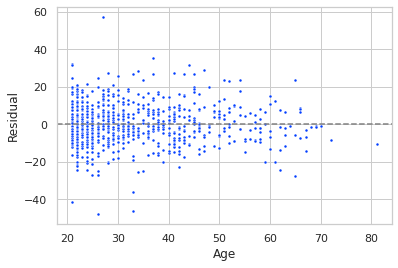

In [57]:
#plotting the residuals against the individual (quantitative) predictor cats

for cat in predict_cats[:-1]: #not outcome
    ax = sns.scatterplot(x=df[cat],y=df_2['Residual'],marker='.')
    plt.axhline(y=0, color='gray',linestyle="--")
    plt.show()

These all look fairly evenly dispersed—more so than age, at least...

In [58]:
print('Mean Absolute Error:', metrics.mean_absolute_error(y_mult, y_pred_mult))
print('Mean Squared Error:', metrics.mean_squared_error(y_mult, y_pred_mult))
print('Root Mean Squared Error:', np.sqrt(metrics.mean_squared_error(y_mult, y_pred_mult)))

Mean Absolute Error: 8.269676817503415
Mean Squared Error: 118.7745897187283
Root Mean Squared Error: 10.898375554124032


Now let's try using ANOVA to compare the blood pressure of different groups
of people (with and w/o diabetes, and of different age groups)

<h1>ANOVA</h1>

In [59]:
# one-way: BP, 'outcome' as categorical

model_diab = ols('BloodPressure ~ C(Outcome)', data=df).fit()
anova_table = sm.stats.anova_lm(model_diab, typ=2)
anova_table

sum_sq     df          F    PR(>F)
C(Outcome)    2990.963536    1.0  20.903727  0.000006
Residual    109601.413909  766.0        NaN       NaN

In [60]:
#and then done again with bioinfokit to make sure numbers are the same

res_d = stat()
res_d.anova_stat(
    df=df,res_var='BloodPressure',
    anova_model='BloodPressure ~ C(Outcome)'
    )
res_d.anova_summary

df         sum_sq      mean_sq          F    PR(>F)
C(Outcome)    1.0    2990.963536  2990.963536  20.903727  0.000006
Residual    766.0  109601.413909   143.082786        NaN       NaN

In [61]:
#tukey HSD test for effect size

pairwise_diabetes=pg.pairwise_tukey(
    data=df,dv='BloodPressure', between='Outcome', effsize = 'cohen',
)

pairwise_diabetes

A  B    mean(A)    mean(B)      diff       se         T   p-tukey     cohen
0  0  1  70.810008  74.950326 -4.140319  0.90557 -4.572059  0.000006 -0.346131

In [62]:
#I've also calculated cohen's d for this manually
#partly just to make sure I know how...

stdev0 = np.var(df.loc[df['Outcome']==0]['BloodPressure'])
stdev1 = np.var(df.loc[df['Outcome']==1]['BloodPressure'])

mean0 = np.mean(df.loc[df['Outcome']==0]['BloodPressure'])
mean1 = np.mean(df.loc[df['Outcome']==1]['BloodPressure'])

cohen = (mean0-mean1)/np.sqrt((stdev0+stdev1)/2)
cohen

-0.3462589922223039

In [63]:
#one-way anova with age as categorical variable

res_a = stat()
res_a.anova_stat(
    df=df,res_var='BloodPressure',anova_model='BloodPressure ~ C(Age_bin)'
    )
res_a.anova_summary

df         sum_sq      mean_sq          F        PR(>F)
C(Age_bin)    4.0   11660.776447  2915.194112  22.037628  3.113515e-17
Residual    763.0  100931.600998   132.282570        NaN           NaN

In [64]:
#tukey HSD with cohen's d

pairwise_age=pg.pairwise_tukey(
    data=df,dv='BloodPressure', between='Age_bin', effsize = 'cohen'
    )

pairwise_age.head()

A         B    mean(A)    mean(B)       diff        se         T  \
0  20 to 29  30 to 39  68.838660  73.436056  -4.597396  1.065720 -4.313887   
1  20 to 29  40 to 49  68.838660  76.868876  -8.030216  1.206269 -6.657067   
2  20 to 29  50 to 59  68.838660  79.807018 -10.968358  1.629354 -6.731723   
3  20 to 29       60+  68.838660  77.972046  -9.133386  2.113735 -4.320969   
4  30 to 39  40 to 49  73.436056  76.868876  -3.432820  1.386633 -2.475651   

        p-tukey     cohen  
0  1.760830e-04 -0.399724  
1  5.337607e-10 -0.698194  
2  3.296774e-10 -0.953653  
3  1.707103e-04 -0.794110  
4  9.725490e-02 -0.298469

In [65]:
#filtering for significance at alpha = 0.05

pairwise_age.query('`p-tukey` < 0.05')

A         B    mean(A)    mean(B)       diff        se         T  \
0  20 to 29  30 to 39  68.838660  73.436056  -4.597396  1.065720 -4.313887   
1  20 to 29  40 to 49  68.838660  76.868876  -8.030216  1.206269 -6.657067   
2  20 to 29  50 to 59  68.838660  79.807018 -10.968358  1.629354 -6.731723   
3  20 to 29       60+  68.838660  77.972046  -9.133386  2.113735 -4.320969   
5  30 to 39  50 to 59  73.436056  79.807018  -6.370962  1.767048 -3.605426   

        p-tukey     cohen  
0  1.760830e-04 -0.399724  
1  5.337607e-10 -0.698194  
2  3.296774e-10 -0.953653  
3  1.707103e-04 -0.794110  
5  3.053772e-03 -0.553928

<h3>Testing assumptions of normality and constancy of variance</h3>

In [66]:
sm.qqplot(res_d.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('ANOVA residuals: Blood Pressure & Outcome')
plt.show()

In [67]:
plt.hist(res_d.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel("Frequency")
plt.title('ANOVA residuals: Blood Pressure & Outcome')
plt.show()

In [68]:
sm.qqplot(res_a.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('ANOVA residuals: Blood Pressure & Age (binned)')
plt.show()

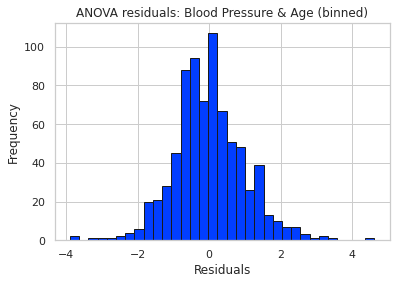

In [69]:
plt.hist(res_a.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel('Residuals')
plt.ylabel("Frequency")
plt.title('ANOVA residuals: Blood Pressure & Age (binned)')
plt.show()

In [70]:
#shapiro-wilks test for normality

w_d, pvalue_d = stats.shapiro(res_d.anova_model_out.resid)
print(w_d, pvalue_d)


0.9879077076911926 5.719261480408022e-06


In [71]:
w_a, pvalue_a = stats.shapiro(res_a.anova_model_out.resid)
print(w_a, pvalue_a)

0.9849592447280884 4.273087483852578e-07


The very low p-values for both mean we can reject the null hypothesis; the data is not normally distributed, as we can see from those fat tails in QQ and histogram plots.

In [72]:
#Levene's test for homogeneity of variance

res_d.levene(df=df,res_var='BloodPressure',xfac_var='Outcome')
res_d.levene_summary

Parameter   Value
0      Test statistics (W)  0.0002
1  Degrees of freedom (Df)  1.0000
2                  p value  0.9893

In [73]:
res_a.levene(df=df,res_var='BloodPressure',xfac_var='Age_bin')
res_a.levene_summary

Parameter   Value
0      Test statistics (W)  0.5740
1  Degrees of freedom (Df)  4.0000
2                  p value  0.6816

P-value > 0.05 for both tests, so the assumption of homongeneity of variance stands.

<h3>Two-way ANOVA<h3)

In [79]:
#may need to convert age_bin to numerical values to do interaction plot
#because statsmodels doesn't seem to like my categorical labels...
#i swear it works half the time but can't figure out why
#run these lines if needed

df.replace(labels,np.arange(len(labels)),inplace=True)

In [81]:
df['Age_bin'].replace(np.arange(len(labels)),labels,inplace=True)

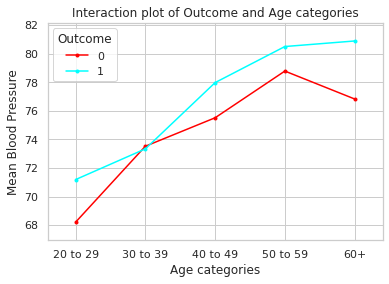

In [82]:
#interaction plot

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['BloodPressure']
    )
plt.xlabel('Age categories')
plt.ylabel('Mean Blood Pressure')
plt.title('Interaction plot of Outcome and Age categories')
plt.show()

In [83]:
#anova with categorical variables age + outcome, and interaction effect

res_2 = stat()
res_2.anova_stat(
    df=df, res_var='Outcome', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.anova_summary

df         sum_sq      mean_sq          F  \
C(Outcome)               1.0     619.526675   619.526675   4.695152   
C(Age_bin)               4.0    9289.339586  2322.334896  17.600074   
C(Outcome):C(Age_bin)    4.0     293.753722    73.438431   0.556561   
Residual               758.0  100018.320601   131.950291        NaN   

                             PR(>F)  
C(Outcome)             3.055867e-02  
C(Age_bin)             7.995175e-14  
C(Outcome):C(Age_bin)  6.942881e-01  
Residual                        NaN

From this it looks like there is a statistically significant difference for both of our main effects, yet not our interaction effect.

Still, let's do some posthoc tests...

In [84]:
#This one's unnecessary bc with only two categories we know which comparison is interesting
#nevertheless we'll leave this line of code here

res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='Glucose', xfac_var='Outcome', 
    anova_model='Glucose ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary


/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2       Diff      Lower      Upper    q-value  p-value
0       1       0  31.454293  27.580829  35.327758  22.544335    0.001

In [85]:
#posthoc test on the age category

res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var='Age_bin', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1    group2       Diff     Lower      Upper   q-value   p-value
0  50 to 59  30 to 39   6.370962  1.545287  11.196636  5.105258  0.003006
1  50 to 59  20 to 29  10.968358  6.518716  15.417999  9.532073  0.001000
4  30 to 39  20 to 29   4.597396  1.686995   7.507796  6.108434  0.001000
7  20 to 29  40 to 49   8.030216  4.735986  11.324445  9.426361  0.001000
8  20 to 29       60+   9.133386  3.360935  14.905836  6.118463  0.001000

In [86]:
res_2 = stat()
res_2.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var=['Outcome','Age_bin'], 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin) + C(Outcome):C(Age_bin)'
    )
res_2.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1         group2       Diff     Lower      Upper   q-value  \
1   (1, 50 to 59)  (1, 20 to 29)   9.312640  1.903558  16.721721  5.640540   
6   (1, 50 to 59)  (0, 20 to 29)  12.293682  5.710684  18.876681  8.380511   
14  (1, 30 to 39)  (0, 20 to 29)   5.130956  0.468291   9.793622  4.938287   
17  (1, 20 to 29)  (1, 40 to 49)   6.786738  0.765313  12.808163  5.057945   
27  (1, 40 to 49)  (0, 20 to 29)   9.767781  4.797978  14.737584  8.820009   
32       (1, 60+)  (0, 20 to 29)  12.682571  0.358436  25.006706  4.618098   
36  (0, 50 to 59)  (0, 20 to 29)  10.576291  2.700691  18.451891  6.026457   
39  (0, 30 to 39)  (0, 20 to 29)   5.314091  0.933807   9.694376  5.444261   
42  (0, 20 to 29)  (0, 40 to 49)   7.307096  1.891657  12.722535  6.055130   
43  (0, 20 to 29)       (0, 60+)   8.624355  0.748755  16.499955  4.914227   

     p-value  
1   0.002913  
6   0.001000  
14  0.018118  
17  0.013539  
27  0.001000  
32  0.037822  
36  0.001000  
39  0.004993  
42  0.001000  
43  0.019187

In [87]:
# #all results from the above

# res_2.tukey_summary

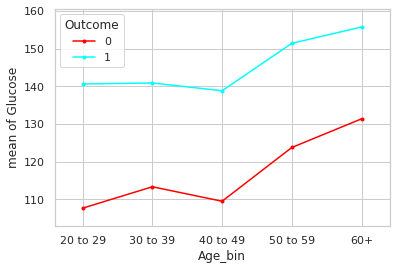

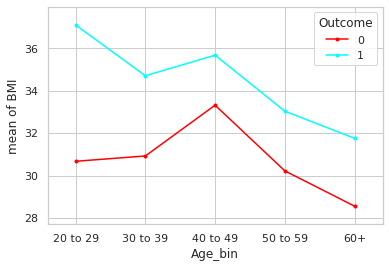

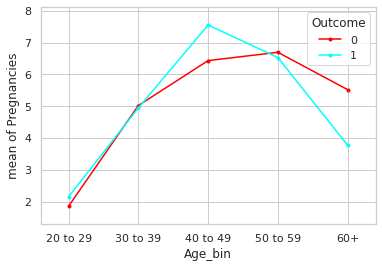

In [88]:
#drawing interaction plots for glucose, BMI, pregnancies as outcome vars
#just to see if there's anything interesting

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['Glucose']
    )
plt.show()

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['BMI']
    )
plt.show()

fig = interaction_plot(
    x=df['Age_bin'], trace=df['Outcome'], response=df['Pregnancies']
    )
plt.show()

Glucose is quite parallel, the others not so much.

Interestingly, the 40 to 49 category looks quite different here for both glucose and BMI, which is not seen in the interaction plot for blood pressure.

What's going on with pregnancies? Might be interesting to explore further at a later time.

Let's try re-running the BP outcome model as a purely additive model, no interaction effect...

In [89]:
#one more anova w/o interaction?

res_2a = stat()
res_2a.anova_stat(
    df=df, res_var='Outcome', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin)'
    )
res_2a.anova_summary

df         sum_sq      mean_sq          F        PR(>F)
C(Outcome)    1.0     619.526675   619.526675   4.706107  3.036412e-02
C(Age_bin)    4.0    9289.339586  2322.334896  17.641138  7.378301e-14
Residual    762.0  100312.074323   131.643142        NaN           NaN

In [90]:
#w/o interaction - posthoc test on outcome

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var='Outcome', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1  group2      Diff     Lower     Upper   q-value  p-value
0       1       0  4.140319  2.435156  5.845481  6.740955    0.001

In [91]:
#w/o interaction - posthoc test on age

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var='Age_bin', 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:402: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[ele] = df[df[xfac_var] == ele].mean().loc[res_var]


group1    group2       Diff     Lower      Upper   q-value   p-value
0  50 to 59  30 to 39   6.370962  1.550969  11.190955  5.111211  0.002959
1  50 to 59  20 to 29  10.968358  6.523955  15.412760  9.543186  0.001000
4  30 to 39  20 to 29   4.597396  1.690421   7.504370  6.115555  0.001000
7  20 to 29  40 to 49   8.030216  4.739864  11.320567  9.437351  0.001000
8  20 to 29       60+   9.133386  3.367731  14.899041  6.125596  0.001000

In [92]:
#w/o interaction - posthoc test on age and outcome pairings

res_2a = stat()
res_2a.tukey_hsd(
    df=df, res_var='BloodPressure', xfac_var=['Outcome','Age_bin'], 
    anova_model='BloodPressure ~ C(Outcome) + C(Age_bin)'
    )
res_2a.tukey_summary.query('`p-value` < 0.05')

/opt/conda/lib/python3.9/site-packages/bioinfokit/analys.py:368: FutureWarning: Dropping of nuisance columns in DataFrame reductions (with 'numeric_only=None') is deprecated; in a future version this will raise TypeError.  Select only valid columns before calling the reduction.
  mult_group[(ele1, ele2)] = df[(df[xfac_var[0]] == ele1) &


group1         group2       Diff     Lower      Upper   q-value  \
1   (1, 50 to 59)  (1, 20 to 29)   9.312640  1.912302  16.712977  5.647117   
6   (1, 50 to 59)  (0, 20 to 29)  12.293682  5.718453  18.868912  8.390282   
14  (1, 30 to 39)  (0, 20 to 29)   5.130956  0.473794   9.788119  4.944045   
17  (1, 20 to 29)  (1, 40 to 49)   6.786738  0.772420  12.801056  5.063842   
27  (1, 40 to 49)  (0, 20 to 29)   9.767781  4.803843  14.731718  8.830293   
32       (1, 60+)  (0, 20 to 29)  12.682571  0.372982  24.992161  4.623483   
36  (0, 50 to 59)  (0, 20 to 29)  10.576291  2.709986  18.442596  6.033483   
39  (0, 30 to 39)  (0, 20 to 29)   5.314091  0.938976   9.689207  5.450609   
42  (0, 20 to 29)  (0, 40 to 49)   7.307096  1.898049  12.716144  6.062190   
43  (0, 20 to 29)       (0, 60+)   8.624355  0.758050  16.490660  4.919957   

     p-value  
1   0.002855  
6   0.001000  
14  0.017863  
17  0.013340  
27  0.001000  
32  0.037370  
36  0.001000  
39  0.004906  
42  0.001000  
43  0.018925

Finally, let's check normality and variance, and plot the residuals (for the original 2-way ANOVA, with interaction)

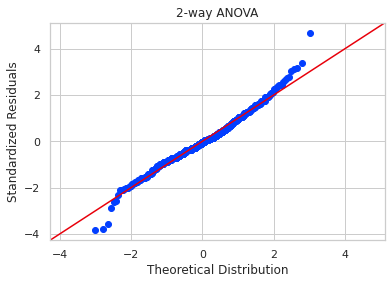

In [93]:
sm.qqplot(res_2.anova_std_residuals,line='45')
plt.xlabel("Theoretical Distribution")
plt.ylabel("Standardized Residuals")
plt.title('2-way ANOVA')
plt.show()

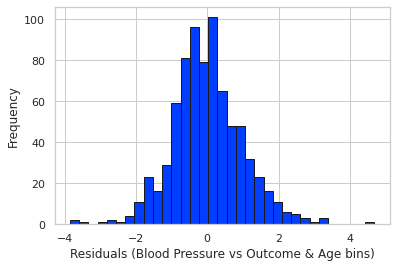

In [94]:
plt.hist(res_2.anova_std_residuals, bins='auto', histtype='bar', ec='k')
plt.xlabel("Residuals (Blood Pressure vs Outcome & Age bins)")
plt.ylabel("Frequency")
plt.show()

In [95]:
w_d, pvalue_d = stats.shapiro(res_2.anova_model_out.resid)
print(w_d, pvalue_d)

0.9854763150215149 6.59820216242224e-07


In [96]:
res_d.levene(df=df,res_var='BloodPressure',xfac_var=['Outcome','Age_bin'])
res_d.levene_summary

Parameter   Value
0      Test statistics (W)  0.3726
1  Degrees of freedom (Df)  9.0000
2                  p value  0.9482

<h1>ANCOVA</h1>

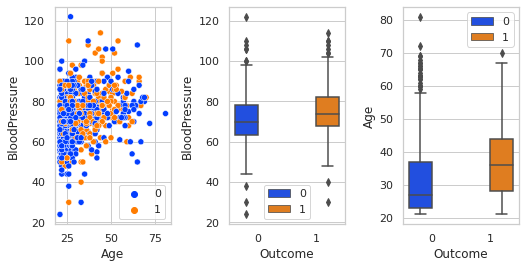

In [97]:
#visualizing the categorical variable and covariate


fig, axs = plt.subplots(ncols=3)
sns.scatterplot(
    data=df, x='Age', y='BloodPressure', hue=df.Outcome.tolist(), ax=axs[0]
    )
sns.boxplot(
    data=df, x='Outcome', y='BloodPressure', hue=df.Outcome.tolist(), ax=axs[1],
    )
sns.boxplot(
    data=df, x='Outcome', y='Age', hue=df.Outcome.tolist(), ax=axs[2]
    )
plt.subplots_adjust(wspace=0.5,right=1.2)


plt.show()

This side-by-side visualization shows that blood pressure of diabetics is slightly higher, and age of diabetics is more noticeably higher, as we've seen previously.


In [98]:
pg.ancova(data=df, dv='BloodPressure', covar='Age', between='Outcome')

Source            SS   DF          F         p-unc       np2
0   Outcome    864.628832    1   6.633816  1.019269e-02  0.008597
1       Age   9893.935767    1  75.910664  1.821118e-17  0.090272
2  Residual  99707.478142  765        NaN           NaN       NaN

Based on the one-way ANCOVA p-value above (~0.02), there is indeed still a significant difference in blood pressure means after adjusting for the effect of age.

After conducting one-way ANCOVA, what are the adjusted means of blood pressure, after adjusting for age?

In [99]:
#using the coefficients from OLS regression to calculate the mean...

x = df[['Age','Outcome']]
y = df['BloodPressure']

In [100]:
mult_lr = LinearRegression()
mult_lr.fit(x,y)

LinearRegression()

In [101]:
print(f'Coefficients: {mult_lr.coef_}')
print(f'intercept: {mult_lr.intercept_}')
print(f'R^2 score: {mult_lr.score(x,y)}')

Coefficients: [0.31446493 2.29215666]
intercept: 61.00184666156675
R^2 score: 0.11443846905792088


In [102]:
y_pred = mult_lr.predict(x)

df_2 = pd.DataFrame({
    'Age': df['Age'],
    'Actual BP': y,
    'Predicted BP': y_pred,
    'Residual': y - y_pred})
df_2.head()

Age  Actual BP  Predicted BP   Residual
0   50       72.0     79.017250  -7.017250
1   31       66.0     70.750259  -4.750259
2   32       64.0     73.356881  -9.356881
3   21       66.0     67.605610  -1.605610
4   33       40.0     73.671346 -33.671346

From the MLR, "Outcome" has a coefficient of 2.2922 → diabetes status means a 2.29 increase in BP.

Plugging into our equation: 61.0018 + 0.3411_mean_age + 2.2922_outcome...

In [103]:
y_adj = (
    mult_lr.intercept_ + 
    mult_lr.coef_[0]*df['Age'].mean() + 
    mult_lr.coef_[1]*df['Outcome']
    )

In [104]:
df_2['Adjusted_mean'] = y_adj
df_2.head()

Age  Actual BP  Predicted BP   Residual  Adjusted_mean
0   50       72.0     79.017250  -7.017250      73.747096
1   31       66.0     70.750259  -4.750259      71.454939
2   32       64.0     73.356881  -9.356881      73.747096
3   21       66.0     67.605610  -1.605610      71.454939
4   33       40.0     73.671346 -33.671346      73.747096

In [105]:
#dataframe of unadjusted vs adjusted means

df_3 = pd.DataFrame({
    'Outcome': i,
    'Mean BP': df.loc[df['Outcome']==i]['BloodPressure'].mean(),
    'Adjusted Mean': (
        mult_lr.intercept_ + 
        mult_lr.coef_[0]*df['Age'].mean() + 
        mult_lr.coef_[1]*i
        )
    } for i in (0,1))

df_3

Outcome    Mean BP  Adjusted Mean
0        0  70.810008      71.454939
1        1  74.950326      73.747096

But what if we try only using samples aged 59 and younger?

In [106]:
df_y = df.query('Age < 60')

df_y.describe()

BloodPressure  Pregnancies     Glucose         BMI         Age  \
count     736.000000   736.000000  736.000000  736.000000  736.000000   
mean       72.006231     3.793478  120.961240   32.581013   31.866848   
std        12.064218     3.379935   30.215799    6.912908    9.906567   
min        24.000000     0.000000   44.000000   18.200000   21.000000   
25%        64.000000     1.000000   99.000000   27.600000   24.000000   
50%        72.000000     3.000000  116.500000   32.300000   29.000000   
75%        80.000000     6.000000  139.000000   36.800000   39.000000   
max       122.000000    17.000000  199.000000   67.100000   59.000000   

          Outcome  
count  736.000000  
mean     0.351902  
std      0.477888  
min      0.000000  
25%      0.000000  
50%      0.000000  
75%      1.000000  
max      1.000000

In [107]:
df_y.shape[0]

736

In [108]:
pg.ancova(data=df_y, dv='BloodPressure', covar='Age', between='Outcome')

Source            SS   DF          F         p-unc       np2
0   Outcome    425.783289    1   3.308938  6.931188e-02  0.004494
1       Age   9660.493365    1  75.075696  2.877789e-17  0.092907
2  Residual  94320.026171  733        NaN           NaN       NaN

In [109]:
#let's just write a function for adjusting the means

def ancova_adjmeans (data, catvar, covar, var):
    """
    returns adjusted means of categorical variable, adjusting for covariate through OLS
    only works for two-category dependent variable because equations are long
    """
    x = data[[covar, catvar]]
    y = data[var]
    linreg = LinearRegression()
    linreg.fit(x,y)
    
#     y_adj = (
#     linreg.intercept_ + 
#         linreg.coef_[0]*data[covar[0]].mean() + 
#         linreg.coef_[1]*data[covar[1]]
#     )
    
    df_adj = pd.DataFrame({
        catvar: i,
        'Mean': data.loc[data[catvar]==i][var].mean(),
        'Adjusted Mean': (
            linreg.intercept_ + 
            linreg.coef_[0]*data[covar].mean() + 
            linreg.coef_[1]*i
            )
        } for i in (0,1))
    
    return df_adj

In [110]:
#let's make sure it works...

ancova_adjmeans(data=df,covar='Age',catvar='Outcome',var='BloodPressure')

Outcome       Mean  Adjusted Mean
0        0  70.810008      71.454939
1        1  74.950326      73.747096

In [111]:
mean_dif = ancova_adjmeans(
    data=df,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Mean'] - ancova_adjmeans(
        data=df,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Mean']

adj_mean_dif = ancova_adjmeans(
    data=df,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Adjusted Mean'] - ancova_adjmeans(
        data=df,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Adjusted Mean']

print(f'Difference between unadjusted means: {abs(mean_dif):.4f}')
print(f'Difference between adjusted means: {abs(adj_mean_dif):.4f}')

Difference between unadjusted means: 4.1403
Difference between adjusted means: 2.2922


In [112]:
ancova_adjmeans(data=df_y,covar='Age',catvar='Outcome',var='BloodPressure')

Outcome       Mean  Adjusted Mean
0        0  70.519703      71.415086
1        1  74.743967      73.094942

In [113]:
mean_dif2 = ancova_adjmeans(
    data=df_y,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Mean'] - ancova_adjmeans(
        data=df_y,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Mean']

adj_mean_dif2 = ancova_adjmeans(
    data=df_y,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Adjusted Mean'] - ancova_adjmeans(
        data=df_y,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Adjusted Mean']

print(f'Difference between unadjusted means: {abs(mean_dif2):.4f}')
print(f'Difference between adjusted means: {abs(adj_mean_dif2):.4f}')

Difference between unadjusted means: 4.2243
Difference between adjusted means: 1.6799


What about if we look only at the samples aged 60 and above?

In [114]:
df_60 = df.query('Age >= 60')

pg.ancova(data=df_60, dv='BloodPressure', covar='Age', between='Outcome')

Source           SS  DF         F     p-unc       np2
0   Outcome   105.635373   1  0.693352  0.411832  0.023350
1       Age     0.269853   1  0.001771  0.966719  0.000061
2  Residual  4418.283209  29       NaN       NaN       NaN

In [115]:
ancova_adjmeans(data=df_60,covar='Age',catvar='Outcome',var='BloodPressure')

Outcome       Mean  Adjusted Mean
0        0  76.830673      76.821691
1        1  80.888889      80.911843

In [116]:
mean_dif3 = ancova_adjmeans(
    data=df_60,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Mean'] - ancova_adjmeans(
        data=df_60,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Mean']

adj_mean_dif3 = ancova_adjmeans(
    data=df_60,covar='Age',catvar='Outcome',var='BloodPressure'
    ).loc[0,'Adjusted Mean'] - ancova_adjmeans(
        data=df_60,covar='Age',catvar='Outcome',var='BloodPressure'
        ).loc[1,'Adjusted Mean']

print(f'Difference between unadjusted means: {abs(mean_dif3):.4f}')
print(f'Difference between adjusted means: {abs(adj_mean_dif3):.4f}')

Difference between unadjusted means: 4.0582
Difference between adjusted means: 4.0902


Our ANCOVA on people 60+ shows that the difference in BP is not statistically significant (p-value 0.69 > 0.05), and there is basically no change between means after adjusting for age since there are few samples and not enough spread in age to have much impact.

In [117]:
df_60.describe()

BloodPressure  Pregnancies     Glucose        BMI        Age    Outcome
count      32.000000     32.00000   32.000000  32.000000  32.000000  32.000000
mean       77.972046      5.03125  138.250000  29.456018  64.843750   0.281250
std        12.081828      2.92359   31.260611   5.183102   4.385529   0.456803
min        50.000000      0.00000   57.000000  19.600000  60.000000   0.000000
25%        71.500000      3.75000  119.750000  26.400000  62.000000   0.000000
50%        78.000000      5.00000  135.500000  29.300000  64.500000   0.000000
75%        84.500000      7.00000  158.000000  33.100000  67.000000   1.000000
max       108.000000     12.00000  197.000000  39.200000  81.000000   1.000000

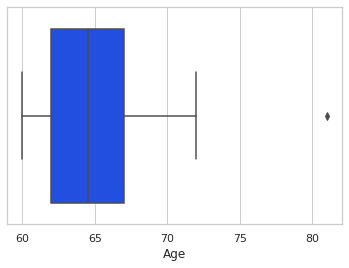

In [118]:
sns.boxplot(data=df_60,x='Age')
plt.show()



<h5>ANCOVA on other quantitative variables</h5>

In [119]:
pg.ancova(data=df, dv='BloodPressure', covar='Outcome', between='Age')

Source            SS   DF         F         p-unc       np2
0       Age  17894.130485   51  2.735537  4.569284e-09  0.163266
1   Outcome    361.531476    1  2.818697  9.360896e-02  0.003927
2  Residual  91707.283424  715       NaN           NaN       NaN

When we run the ANCOVA the other way around, finding the differences in BP betwen ages and adjusting for the bias of outcome, "Age" is still significant (p-value < 0.05), but "Outcome" is not.

What about other quantitative variables?

In [120]:
#starting with Pregnancies...

pg.ancova(data=df,dv='BloodPressure',covar='Pregnancies',between='Outcome')

Source             SS   DF          F         p-unc       np2
0      Outcome    1610.396977    1  11.615126  6.883997e-04  0.014956
1  Pregnancies    3536.812118    1  25.509560  5.508272e-07  0.032270
2     Residual  106064.601791  765        NaN           NaN       NaN

In [121]:
#actually let's just put em all together

df_ancova = pd.DataFrame({
    'Variable':[],
    'SS (outcome)':[],'SS (covar)':[],
    'p-unc (outcome)':[],
    'p-unc (covar)':[],
    'np2 (outcome)':[],
    'np2 (covar)':[]
    })

for col in cols_selected[1:-1]:
    ancova = pg.ancova(
        data=df, dv='BloodPressure', covar=col, between='Outcome'
        )
    df_ancova = df_ancova.append({
    'Variable':ancova.loc[1,'Source'],
    'SS (outcome)':ancova.loc[0,'SS'],
    'SS (covar)':ancova.loc[1,'SS'],
    'p-unc (outcome)':ancova.loc[0,'p-unc'],
    'p-unc (covar)':ancova.loc[1,'p-unc'],
    'np2 (outcome)':ancova.loc[0,'np2'],
    'np2 (covar)':ancova.loc[1,'np2'],        
    },
    ignore_index=True
    )

df_ancova

Variable  SS (outcome)   SS (covar)  p-unc (outcome)  p-unc (covar)  \
0  Pregnancies   1610.396977  3536.812118         0.000688   5.508272e-07   
1      Glucose    445.186636  2887.145144         0.074423   6.254593e-06   
2          BMI    704.952740  6619.032071         0.022387   5.166741e-12   
3          Age    864.628832  9893.935767         0.010193   1.821118e-17   

   np2 (outcome)  np2 (covar)  
0       0.014956     0.032270  
1       0.004154     0.026342  
2       0.006799     0.060392  
3       0.008597     0.090272

In [122]:
#let's just look at that glucose one a little more...

ancova_adjmeans(data=df,covar='Glucose',catvar='Outcome',var='BloodPressure')

Outcome       Mean  Adjusted Mean
0        0  70.810008      71.614168
1        1  74.950326      73.450028

In [123]:
#I wonder what the r^2 is for diabetes and glucose, actually?

res = stats.linregress(x=df['Glucose'],y=df['Outcome'])

print(f'coeff: {res.slope}')
print(f'intercept: {res.intercept}')
print(f'p-value: {res.pvalue}')
print(f'r^2: {res.rvalue**2}')
print(f'std err: {res.stderr}')

coeff: 0.007724182953783579
intercept: -0.5909326459601283
p-value: 2.937417508733906e-48
r^2: 0.24295871762556712
std err: 0.000492642306739885


What about ANCOVA with multiple covariates?

In [124]:
pg.ancova(
        data=df, dv='BloodPressure',
        covar=['Age','Glucose','BMI','Pregnancies'],
        between='Outcome'
        )


Source            SS   DF          F         p-unc       np2
0      Outcome    167.079628    1   1.395705  2.378126e-01  0.001828
1          Age   5710.109934    1  47.699594  1.048346e-11  0.058910
2      Glucose    831.577045    1   6.946607  8.568616e-03  0.009034
3          BMI   6987.029232    1  58.366382  6.538302e-14  0.071147
4  Pregnancies    193.784160    1   1.618782  2.036497e-01  0.002120
5     Residual  91218.884904  762        NaN           NaN       NaN

Interestingly, "Outcome" and the covariate "Pregnancies" are both above our desired alpha-level of significance here, and the covariate "Glucose" is below... further interpretation however is beyond the scope of this report.

<h1>Power Analysis</h1>

Let's see what the power of our dataset is given the 768 samples in it.

Using the cohen's d metric from our earlier one-way ANOVA of blood pressure and different outcome categories...

In [125]:
effect_size = abs(pairwise_diabetes.loc[0,'cohen'])
effect_size

0.3461306647524267

In [126]:
sample_size = df.shape[0]

print(f'For effect size of {effect_size:.4f} and {df.shape[0]} samples:')

power_analysis = sm.stats.TTestIndPower()
power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.05)

print(f'Power at alpha=0.05: {power:.4f}')

power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.01)
print(f'Power at alpha=0.01: {power:.4f}')

For effect size of 0.3461 and 768 samples:
Power at alpha=0.05: 1.0000
Power at alpha=0.01: 1.0000


In [127]:
#the cohen's d effect size of age bins...

In [128]:
pairwise_age[['A','B','cohen']]

A         B     cohen
0  20 to 29  30 to 39 -0.399724
1  20 to 29  40 to 49 -0.698194
2  20 to 29  50 to 59 -0.953653
3  20 to 29       60+ -0.794110
4  30 to 39  40 to 49 -0.298469
5  30 to 39  50 to 59 -0.553928
6  30 to 39       60+ -0.394385
7  40 to 49  50 to 59 -0.255459
8  40 to 49       60+ -0.095916
9  50 to 59       60+  0.159543

In [129]:
abs(pairwise_age['cohen']).mean()

0.46033818841438945

In [130]:
effect_size = abs(pairwise_age['cohen']).mean()

print(f'For effect size of {effect_size:.4f} and {df.shape[0]} samples:')

power_analysis = sm.stats.TTestIndPower()
power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.05)

print(f'Power at alpha=0.05: {power:.4f}')

power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.01)
print(f'Power at alpha=0.01: {power:.4f}')

For effect size of 0.4603 and 768 samples:
Power at alpha=0.05: 1.0000
Power at alpha=0.01: 1.0000


In [131]:
effect_size = abs(pairwise_age['cohen']).max()

print(f'For effect size of {effect_size:.4f} and {df.shape[0]} samples:')

power_analysis = sm.stats.TTestIndPower()
power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.05)

print(f'Power at alpha=0.05: {power:.4f}')

power = power_analysis.solve_power(effect_size = effect_size, 
                                   nobs1 = sample_size,
                                   alpha = 0.01)
print(f'Power at alpha=0.01: {power:.4f}')

For effect size of 0.9537 and 768 samples:
Power at alpha=0.05: 1.0000
Power at alpha=0.01: 1.0000


In [132]:
#table of effect sizes for the sample size we do have

df_power = pd.DataFrame({
    'Effect Size':[],
    'Alpha':[],
    'Power':[]
    })

for es in (0.15, 0.2, 0.5, 0.8):
    for al in (0.05, 0.01):
        power_analysis = sm.stats.TTestIndPower()
        power = power_analysis.solve_power(
            effect_size = es,
            nobs1 = sample_size,
            alpha=al
            )
        
        df_power = df_power.append({
            'Effect Size':es,
            'Alpha':al,
            'Power':power
            },ignore_index=True)


df_power

Effect Size  Alpha     Power
0         0.15   0.05  0.835860
1         0.15   0.01  0.640718
2         0.20   0.05  0.974812
3         0.20   0.01  0.909733
4         0.50   0.05  1.000000
5         0.50   0.01  1.000000
6         0.80   0.05  1.000000
7         0.80   0.01  1.000000

In [133]:
df_sampsize = pd.DataFrame({
    'Effect Size':[],
    'Alpha':[],
    'Power':[],
    'Sample size':[]
    })

for es in (0.15, 0.2, 0.5, 0.8):
    for al in (0.05, 0.01):
        for pwr in (0.8, 0.95):
            power_analysis = sm.stats.TTestIndPower()
            samp_size = power_analysis.solve_power(
                effect_size = es,
                power=pwr,
                alpha=al,
                )

            df_sampsize = df_sampsize.append({
                'Effect Size':es,
                'Alpha':al,
                'Power':pwr,
                'Sample size':samp_size
                },ignore_index=True)


df_sampsize

#sort this maybe?

Effect Size  Alpha  Power  Sample size
0          0.15   0.05   0.80   698.638162
1          0.15   0.05   0.95  1156.046544
2          0.15   0.01   0.80  1039.790454
3          0.15   0.01   0.95  1585.141099
4          0.20   0.05   0.80   393.405699
5          0.20   0.05   0.95   650.697425
6          0.20   0.01   0.80   585.609280
7          0.20   0.01   0.95   892.368737
8          0.50   0.05   0.80    63.765612
9          0.50   0.05   0.95   104.927947
10         0.50   0.01   0.80    95.103621
11         0.50   0.01   0.95   144.182710
12         0.80   0.05   0.80    25.524573
13         0.80   0.05   0.95    41.594130
14         0.80   0.01   0.80    38.188313
15         0.80   0.01   0.95    57.354873

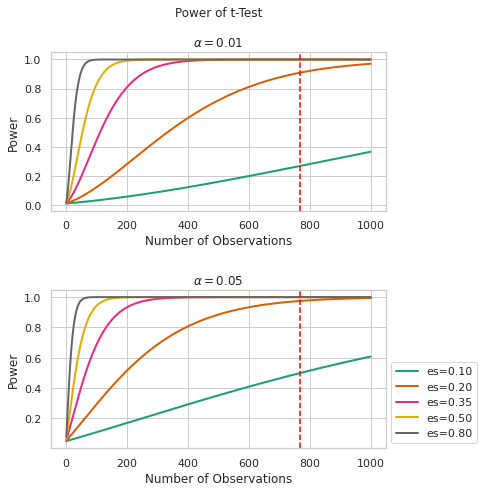

In [134]:
#plots to show where our diabetes dataset lies in this world...

fig = plt.figure()

ax = fig.add_subplot(2,1,1)
fig = sm.stats.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs= np.arange(2,1000),
    effect_size=np.array([0.1, 0.2, 0.346, 0.5, 0.8]),
    alpha=0.01,
    ax=ax, 
    title='Power of t-Test' + '\n\n' + r'$\alpha = 0.01$',
    )
ax.get_legend().remove()
ax.axvline(x=df.shape[0],linestyle='--',color='#ff0000')
plt.ylabel('Power')

ax = fig.add_subplot(2,1,2)
fig = sm.stats.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs= np.arange(2,1000),
    effect_size=np.array([0.1, 0.2, 0.346, 0.5, 0.8]),
    alpha=0.05,
    ax=ax, title=r'$\alpha = 0.05$')
ax.axvline(x=df.shape[0],linestyle='--',color='#ff0000')

plt.ylabel('Power')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.subplots_adjust(top=1.5,hspace=0.5)

For medium and large effect sizes, we can be quite certain that we have not made Type II errors.

For very low effect sizes, not so much...

What if we look only at people age 60+?

In [135]:
#analyzing the sample size of the 60+ subset

nobs1_60 = df_60.shape[0]

#for a very large effect, what would be the power?

power = power_analysis.solve_power(
    effect_size = 0.99, 
    nobs1 = nobs1_60,
    alpha = 0.05)

power

0.9736875812391568

In [136]:
nobs1_60

32

In [137]:
df_power = pd.DataFrame({
    'Effect Size':[],
    'Alpha':[],
    'Power':[]
    })

for es in (0.15, 0.2, 0.5, 0.8):
    for al in (0.05, 0.01):
        power_analysis = sm.stats.TTestIndPower()
        power = power_analysis.solve_power(
            effect_size = es,
            nobs1 = nobs1_60,
            alpha=al
            )
        
        df_power = df_power.append({
            'Effect Size':es,
            'Alpha':al,
            'Power':power
            },ignore_index=True)


df_power

Effect Size  Alpha     Power
0         0.15   0.05  0.090842
1         0.15   0.01  0.023993
2         0.20   0.05  0.123540
3         0.20   0.01  0.036568
4         0.50   0.05  0.503638
5         0.50   0.01  0.264654
6         0.80   0.05  0.882995
7         0.80   0.01  0.704814

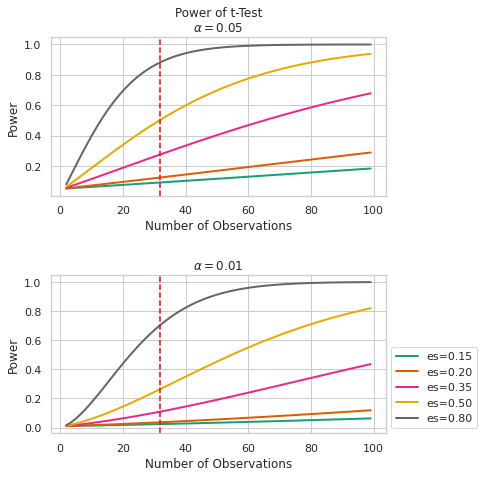

In [138]:
#for our n=32 sample size...

fig = plt.figure()

ax = fig.add_subplot(2,1,1)
sm.stats.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs= np.arange(2,100),
    effect_size=np.array([0.15, 0.2, 0.346, 0.5, 0.8]),
    alpha=0.05,
    title='Power of t-Test' + '\n'+ r'$\alpha = 0.05$',
    ax=ax
    )
ax.get_legend().remove()
plt.axvline(x=df_60.shape[0],linestyle='--',color='#ff0000')
plt.ylabel('Power')

ax = fig.add_subplot(2,1,2)
fig = sm.stats.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs= np.arange(2,100),
    effect_size=np.array([0.15, 0.2, 0.346, 0.5, 0.8]),
    alpha=0.01,
    ax=ax, title=r'$\alpha = 0.01$')
plt.axvline(x=df_60.shape[0],linestyle='--',color='#ff0000')

plt.ylabel('Power')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.subplots_adjust(top=1.5,hspace=0.5)

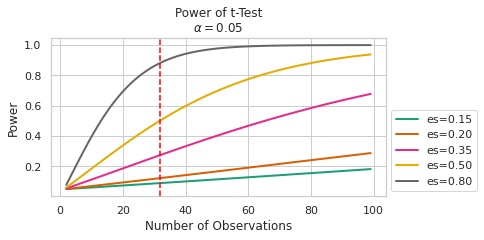

In [139]:
#just the alpha=0.05 for putting in writeup because it fits space better

fig = plt.figure()

ax = fig.add_subplot(2,1,1)
sm.stats.TTestIndPower().plot_power(
    dep_var='nobs',
    nobs= np.arange(2,100),
    effect_size=np.array([0.15, 0.2, 0.346, 0.5, 0.8]),
    alpha=0.05,
    title='Power of t-Test' + '\n'+ r'$\alpha = 0.05$',
    ax=ax
    )
ax.get_legend().remove()
ax.axvline(x=df_60.shape[0],linestyle='--',color='#ff0000')

plt.ylabel('Power')
plt.legend(bbox_to_anchor=(1,0), loc="lower left")
plt.subplots_adjust(top=1.5,hspace=0.5)

As seen from the power curves, even detecting medium effect sizes does not have very high power with a small sample size.

So it seems we cannot come to any meaningful conclusions about the 60+ age group alone without a high probability of making Type II errors.